# Import librairies

In [2]:
import torch 
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw
import math
import numpy as np

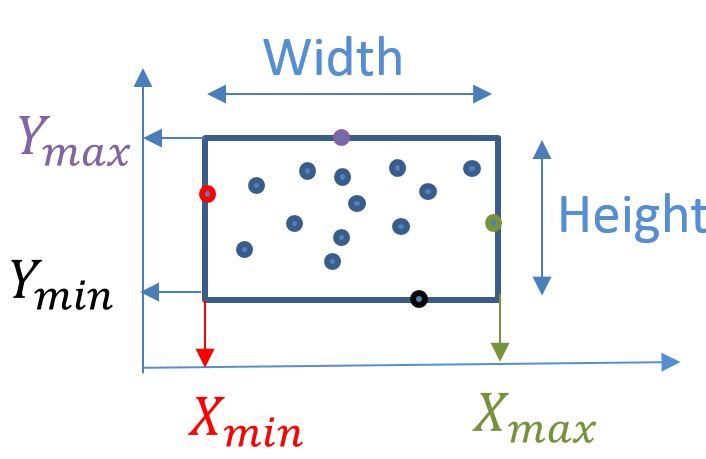



1) Data augmentation and transformation

**Remarques** : 

- RandomErasing est appliqué après la conversion de l'image en un tenseur PyTorch (T.ToTensor()), car cette opération modifie directement les valeurs des pixels du tenseur de l'image.
- RandomAffine permet non seulement de faire pivoter l'image, mais aussi d'appliquer des translations, des mises à l'échelle et des cisaillements si désiré. Les paramètres degrees=(-15, 15) définissent l'intervalle de rotation.
- Le paramètre p dans RandomHorizontalFlip et RandomErasing spécifie la probabilité que la transformation soit appliquée à une image donnée.

Remarque sur les labels : 0 0.706953 0.419896 0.423594 0.227292 = **classe_id x_center y_center width height**

In [44]:
def load_labels(label_path):
    """Charge les labels depuis un fichier txt et les convertit en tensors."""
    labels = []
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            cls, x_center, y_center, width, height = map(float, line.split())
            labels.append(int(cls))
            boxes.append([x_center, y_center, width, height])
    return torch.tensor(labels), torch.tensor(boxes)

def apply_transforms(image, boxes):
    """Applique les transformations à l'image et ajuste les bounding boxes si nécessaire."""
    # Rotation ici comme exemple de transformation
    rotated_image = TF.rotate(image, 45)

    # TODO: Appliquer les transformations aux bounding boxes si nécessaire
    # Pour cet exemple, nous retournons les boîtes originales non transformées.
    # Dans un cas réel, il faudrait ajuster ces boîtes selon la transformation appliquée.
    return rotated_image, boxes

def show_image_with_boxes(image, boxes, labels, class_names):
    """Affiche l'image avec les bounding boxes et les labels."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label in zip(boxes, labels):
        # Convertir de centre x,y,width,height à xmin,ymin,xmax,ymax
        xmin = (box[0] - box[2] / 2) * image.width
        ymin = (box[1] - box[3] / 2) * image.height
        xmax = (box[0] + box[2] / 2) * image.width
        ymax = (box[1] + box[3] / 2) * image.height
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, class_names[label], color='blue', fontsize=12)

    plt.show()


def rotate_box(box, angle, image_width, image_height):
    """Rotates a bounding box by 'angle' degrees.

    Args:
        box (tensor): The bounding box, format [x_center, y_center, width, height].
        angle (float): The rotation angle in degrees, counter-clockwise.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        tensor: The rotated bounding box.
    """
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Calculate the rotation matrix
    cos_val = math.cos(angle_rad)
    sin_val = math.sin(angle_rad)
    rotation_matrix = np.array([[cos_val, -sin_val], [sin_val, cos_val]])

    # Convert box to corners (top-left and bottom-right)
    x_center, y_center, width, height = box
    x_center_abs = x_center * image_width
    y_center_abs = y_center * image_height
    width_abs = width * image_width
    height_abs = height * image_height
    corners = np.array([
        [x_center_abs - width_abs / 2, y_center_abs - height_abs / 2],  # Top-left
        [x_center_abs + width_abs / 2, y_center_abs + height_abs / 2]   # Bottom-right
    ])

    # Move corners to origin (for rotation), rotate, and move back
    corners_centered = corners - np.array([image_width / 2, image_height / 2])
    corners_rotated = np.dot(corners_centered, rotation_matrix)
    corners_moved_back = corners_rotated + np.array([image_width / 2, image_height / 2])

    # Convert rotated corners back to box format
    x_min, y_min = corners_moved_back[0]
    x_max, y_max = corners_moved_back[1]
    new_width = x_max - x_min
    new_height = y_max - y_min
    new_x_center = x_min + new_width / 2
    new_y_center = y_min + new_height / 2

    # Normalize the coordinates
    new_box = [
        new_x_center / image_width, new_y_center / image_height,
        new_width / image_width, new_height / image_height
    ]
    return torch.tensor(new_box)

def apply_transforms(image, boxes):
    """Applique les transformations à l'image et ajuste les bounding boxes."""
    # Rotation de l'image
    angle =  80 # On definit l'angle de rotation ici
    rotated_image = TF.rotate(image, angle)

    # Ajuster les bounding boxes
    transformed_boxes = [rotate_box(box, angle, image.width, image.height) for box in boxes]

    return rotated_image, torch.stack(transformed_boxes)


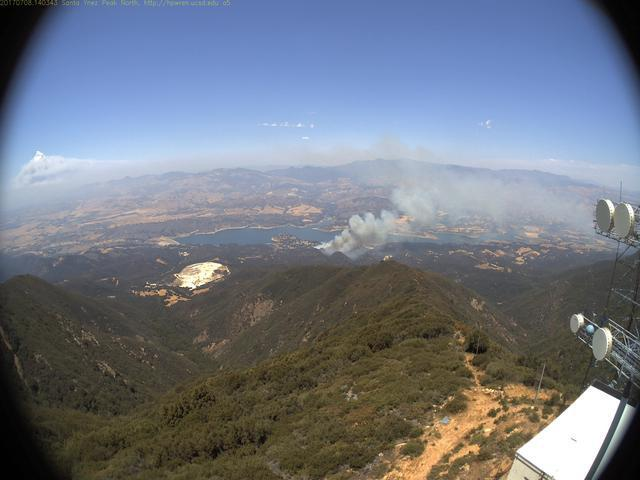

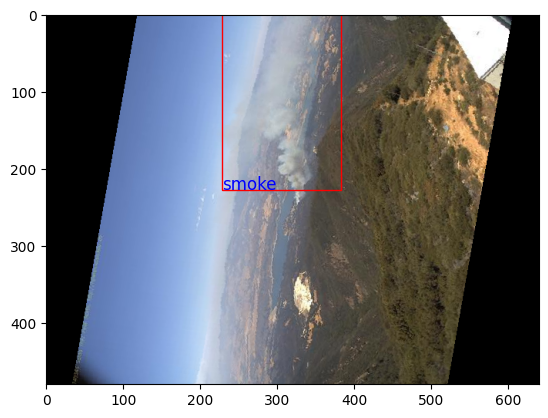

In [45]:
#Emplacements de votre image et de votre fichier d'annotations
image_path = "images/aiformankind_v1_000007.jpg"
label_path = "images/aiformankind_v1_000007.txt"

# Chargement de l'image
image = Image.open(image_path)

# Chargement des labels
class_names = ["smoke", "Classe2", "Classe3"]  # Mettez à jour avec vos classes réelles
labels, boxes = load_labels(label_path)


# Appliquez les transformations et montrez l'image avec les bounding boxes ajustées
transformed_image, transformed_boxes = apply_transforms(image, boxes)
display(image)
show_image_with_boxes(transformed_image, transformed_boxes, labels, class_names)

Faire sur d'autres images -> code qui enregistre les images automatiquement et leur nouveaux labels => dans un dossier 